In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess_data(df):
    """Complete preprocessing pipeline for demand forecasting data"""

     # 0. Drop old record_id and create new sequential index
    if 'record_ID' in df.columns:
        df = df.drop(columns=['record_ID'])
    df = df.reset_index(drop=True)  # Creates new 0-based index
    
    # 1. Clean data - remove rows where total_price > base_price
    print(f"Original data shape: {df.shape}")
    df = df[df['total_price'] <= df['base_price']].copy()
    print(f"After removing invalid prices: {df.shape}")
    
    # 2. Transform IDs to categorical
    df['store_id'] = df['store_id'].astype('category')
    df['sku_id'] = df['sku_id'].astype('category')
    
    # 3. Add discount ratio and drop total_price
    df['discount_ratio'] = (df['base_price'] - df['total_price']) / df['base_price']
    df = df.drop(columns=['total_price'])
    
    # 4. Handle datetime ... later

    
    # 5. Outlier detection and removal
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='units_sold')
    plt.title('Boxplot of Units Sold Before Outlier Removal')
    plt.show()
    
    # Calculate IQR for units_sold
    Q1 = df['units_sold'].quantile(0.25)
    Q3 = df['units_sold'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    original_size = len(df)
    df = df[(df['units_sold'] >= lower_bound) & (df['units_sold'] <= upper_bound)]
    print(f"Removed {original_size - len(df)} outliers ({((original_size - len(df))/original_size)*100:.2f}% of data)")
    
    # 6. Feature scaling
    numeric_cols = ['base_price', 'discount_ratio', 'units_sold']
    
    
    # Standard scale other numeric features
    feature_scaler = StandardScaler()
    df[numeric_cols[:-1]] = feature_scaler.fit_transform(df[numeric_cols[:-1]])
    
    # Show preprocessing results
    print("\nFinal preprocessed data:")
    print(df.head())
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    return df


In [2]:
def prepare_time_series(df):
    # Convert and extract datetime
    df['week'] = pd.to_datetime(df['week'])
    df['year'] = df['week'].dt.year
    df['week_of_year'] = df['week'].dt.isocalendar().week
    df['day_of_year'] = df['week'].dt.dayofyear
    
    # Lagged features
    for lag in [1, 2, 4, 12]:
        df[f'sales_lag_{lag}'] = df.groupby(['sku_id', 'store_id'])['units_sold'].shift(lag)
    
    # Rolling stats
    df['rolling_avg_4w'] = df.groupby(['sku_id', 'store_id'])['units_sold'].transform(
        lambda x: x.rolling(4, min_periods=1).mean()
    )
    
    # Drop rows with NaN from lagging
    df = df.dropna()
    return df



In [3]:
df = pd.read_csv('dataset_devcamp.csv')

Original data shape: (133980, 8)
After removing invalid prices: (130946, 8)


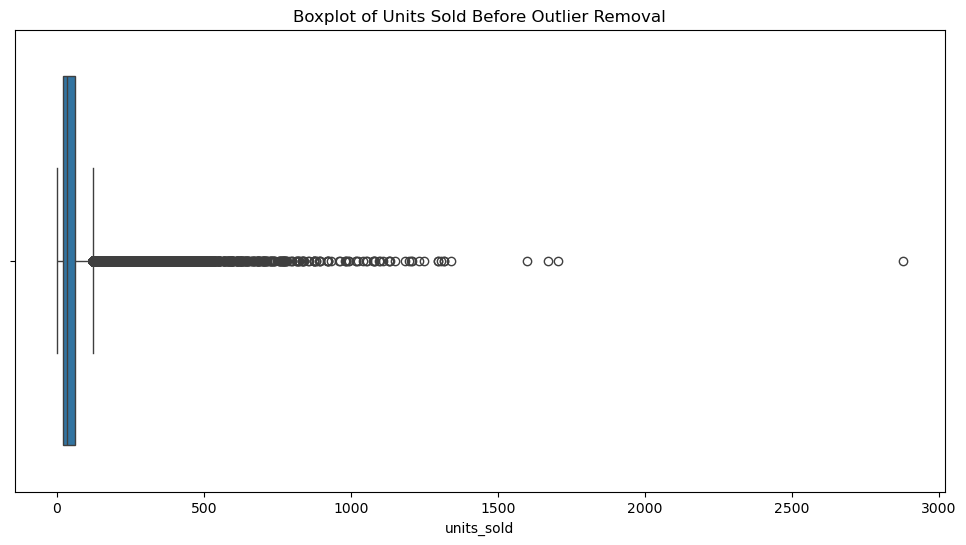

Removed 9171 outliers (7.00% of data)

Final preprocessed data:
         week store_id  sku_id  base_price  is_featured_sku  is_display_sku  \
0  2011-01-17     8091  216418   -0.989567                0               0   
1  2011-01-17     9672  223153    0.123547                1               1   
2  2011-01-17     9672  223245   -0.137240                0               0   
3  2011-01-17     9672  222765    0.168072                0               0   
5  2011-01-17     9672  219029    0.931350                0               0   

   units_sold  discount_ratio  
0          20        0.784159  
1         109        1.567048  
2          61       -0.460796  
3          49       -0.460796  
5          39       -0.460796  

Missing values:
week               0
store_id           0
sku_id             0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
discount_ratio     0
dtype: int64


,week,store_id,sku_id,base_price,is_featured_sku,is_display_sku,units_sold,discount_ratio
0,2011-01-17,8091,216418,-0.989567,0,0,20,0.784159
1,2011-01-17,9672,223153,0.123547,1,1,109,1.567048
2,2011-01-17,9672,223245,-0.137240,0,0,61,-0.460796
3,2011-01-17,9672,222765,0.168072,0,0,49,-0.460796
5,2011-01-17,9672,219029,0.931350,0,0,39,-0.460796


In [4]:
prepro_df = preprocess_data(df)
prepro_df.head()

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Apply time-series preparation
final_df = prepare_time_series(prepro_df)

# Separate features and target
X = final_df.drop(columns=['units_sold', 'week'])
y = final_df['units_sold']

# One-Hot Encoding for categoricals
cat_cols = ['store_id', 'sku_id']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[cat_cols])
encoded_feature_names = encoder.get_feature_names_out(cat_cols)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Reset index for both DataFrames before concatenation
numeric_cols = [col for col in X.columns if col not in cat_cols]
X_encoded_df = X_encoded_df.reset_index(drop=True)
X_numeric = X[numeric_cols].reset_index(drop=True)

# Combine with numeric features
X_final = pd.concat([X_encoded_df, X_numeric], axis=1)

print(f"Total features after encoding: {X_final.shape[1]}")
print(f"NaN values in final DataFrame: {X_final.isnull().sum().sum()}")  # Should be 0

X_final.head()


C:\Users\bking\AppData\Local\Temp\ipykernel_10112\3816713201.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'sales_lag_{lag}'] = df.groupby(['sku_id', 'store_id'])['units_sold'].shift(lag)
C:\Users\bking\AppData\Local\Temp\ipykernel_10112\3816713201.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'sales_lag_{lag}'] = df.groupby(['sku_id', 'store_id'])['units_sold'].shift(lag)
C:\Users\bking\AppData\Local\Temp\ipykernel_10112\3816713201.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

Total features after encoding: 116
NaN values in final DataFrame: 0


,store_id_8023,store_id_8058,store_id_8063,store_id_8091,store_id_8094,store_id_8095,store_id_8121,store_id_8218,store_id_8222,store_id_8317,...,is_display_sku,discount_ratio,year,week_of_year,day_of_year,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_12,rolling_avg_4w
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.460796,2011,15,101,73.0,117.0,80.0,49.0,91.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.460796,2011,15,101,30.0,77.0,66.0,50.0,55.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.460796,2011,15,101,15.0,18.0,26.0,21.0,17.75
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.641076,2011,15,101,30.0,19.0,33.0,30.0,20.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.460796,2011,15,101,53.0,100.0,37.0,33.0,66.25


In [6]:
# Check if PCA is needed (typically when >100 features)
if X_final.shape[1] > 100:
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_pca = pca.fit_transform(X_final)
    print(f"Reduced from {X_final.shape[1]} to {pca.n_components_} features")
else:
    X_pca = X_final

X_pca

Reduced from 116 to 3 features


array([[ 83.0063231 ,  97.61905657, -32.39263522],
       [ 82.46438898,  37.10678264,   3.30839757],
       [ 81.60996755, -43.70853871,   4.26639635],
       ...,
       [ 92.26904341, 119.09599656, -15.04651118],
       [ 91.80678871,  67.78037375,  14.40707256],
       [ 91.17355665,  -3.56256085,  31.49238734]])

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, X, y, use_pca=False):
    tscv = TimeSeriesSplit(n_splits=3)
    metrics = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        if use_pca:
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        metrics.append({
            'MAE': mean_absolute_error(y_test, preds),
            'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
            'MAPE': np.mean(np.abs((y_test - preds) / y_test)) * 100
        })
    
    return pd.DataFrame(metrics).mean()

In [9]:
import lightgbm as lgb

# No PCA needed - LightGBM handles high dimensionality well
lgb_model = lgb.LGBMRegressor(
    categorical_feature=cat_cols,
    objective='regression',
    metric='rmse',
    n_estimators=500
)

lgb_results = evaluate_model(lgb_model, X_final, y)
print("LightGBM Results:")
print(lgb_results)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: week_of_year